# Close leaves in a decision trees

A decision tree computes a partition of the feature space. We can wonder which leave is close to another one even though the predict the same value (or class). Do they share a border ?

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## A simple tree

In [3]:
import numpy
X = numpy.array([[10, 0], [10, 1], [10, 2],
                 [11, 0], [11, 1], [11, 2],
                 [12, 0], [12, 1], [12, 2]])
y = list(range(X.shape[0]))

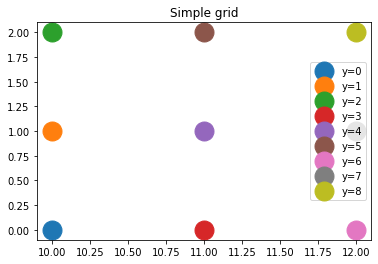

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
for i in range(X.shape[0]):
    ax.plot([X[i, 0]], [X[i, 1]], 'o', ms=19, label="y=%d" % y[i])
ax.legend()
ax.set_title("Simple grid");

In [5]:
from sklearn.tree import DecisionTreeClassifier
clr = DecisionTreeClassifier(max_depth=5)
clr.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

The contains the following list of leaves.

In [6]:
from mlinsights.mltree import tree_leave_index
tree_leave_index(clr)

[2, 4, 5, 8, 10, 11, 13, 15, 16]

Let's compute the neighbors for each leave.

In [7]:
from mlinsights.mltree import tree_leave_neighbors
neighbors = tree_leave_neighbors(clr)
neighbors

{(2, 8): [(0, (10.0, 0.0), (11.0, 0.0))],
 (2, 4): [(1, (10.0, 0.0), (10.0, 1.0))],
 (4, 10): [(0, (10.0, 1.0), (11.0, 1.0))],
 (4, 5): [(1, (10.0, 1.0), (10.0, 2.0))],
 (5, 11): [(0, (10.0, 2.0), (11.0, 2.0))],
 (8, 13): [(0, (11.0, 0.0), (12.0, 0.0))],
 (8, 10): [(1, (11.0, 0.0), (11.0, 1.0))],
 (10, 15): [(0, (11.0, 1.0), (12.0, 1.0))],
 (10, 11): [(1, (11.0, 1.0), (11.0, 2.0))],
 (11, 16): [(0, (11.0, 2.0), (12.0, 2.0))],
 (13, 15): [(1, (12.0, 0.0), (12.0, 1.0))],
 (15, 16): [(1, (12.0, 1.0), (12.0, 2.0))]}

And let's explain the results by drawing the segments ``[x1, x2]``.

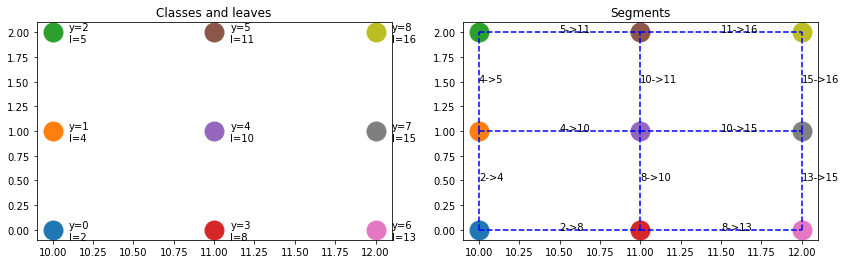

In [8]:
from mlinsights.mltree import predict_leaves
leaves = predict_leaves(clr, X)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14,4))
for i in range(X.shape[0]):
    ax[0].plot([X[i, 0]], [X[i, 1]], 'o', ms=19)
    ax[1].plot([X[i, 0]], [X[i, 1]], 'o', ms=19)
    ax[0].text(X[i, 0] + 0.1, X[i, 1] - 0.1, "y=%d\nl=%d" % (y[i], leaves[i]))
    
for edge, segments in neighbors.items():
    for segment in segments:
        # leaves l1, l2 are neighbors
        l1, l2 = edge
        # the common border is [x1, x2]
        x1 = segment[1]
        x2 = segment[2]
        ax[1].plot([x1[0], x2[0]], [x1[1], x2[1]], 'b--')
        ax[1].text((x1[0] + x2[0])/2, (x1[1] + x2[1])/2, "%d->%d" % edge)
ax[0].set_title("Classes and leaves")
ax[1].set_title("Segments");

## On Iris

In [9]:
from sklearn.datasets import load_iris
iris = load_iris()

In [10]:
X = iris.data[:, :2]
y = iris.target

In [11]:
clr = DecisionTreeClassifier(max_depth=3)
clr.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

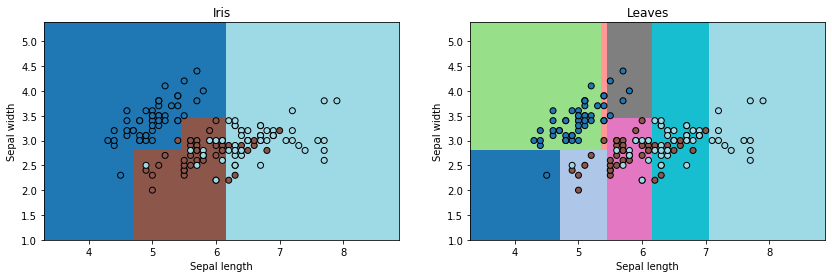

In [12]:
import matplotlib.pyplot as plt

def draw_border(clr, X, y, fct=None, incx=1, incy=1, figsize=None, border=True, ax=None):

    # see https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
    # https://matplotlib.org/examples/color/colormaps_reference.html
    _unused_ = ["Red", "Green", "Yellow", "Blue", "Orange", "Purple", "Cyan",
              "Magenta", "Lime", "Pink", "Teal", "Lavender", "Brown", "Beige",
              "Maroon", "Mint", "Olive", "Coral", "Navy", "Grey", "White", "Black"]

    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - incx, X[:, 0].max() + incx
    y_min, y_max = X[:, 1].min() - incy, X[:, 1].max() + incy
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h), numpy.arange(y_min, y_max, h))
    if fct is None:
        Z = clr.predict(numpy.c_[xx.ravel(), yy.ravel()])
    else:
        Z = fct(clr, numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    cmap = plt.cm.tab20
    Z = Z.reshape(xx.shape)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize or (4, 3))
    ax.pcolormesh(xx, yy, Z, cmap=cmap)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=cmap)
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax

fig, ax = plt.subplots(1, 2, figsize=(14,4))
draw_border(clr, X, y, border=False, ax=ax[0])
ax[0].set_title("Iris")
draw_border(clr, X, y, border=False, ax=ax[1],
            fct=lambda m, x: predict_leaves(m, x))
ax[1].set_title("Leaves");

In [13]:
neighbors = tree_leave_neighbors(clr)
list(neighbors.items())[:2]

[((3, 4),
  [(0,
    (4.650000095367432, 2.4750000834465027),
    (5.025000095367432, 2.4750000834465027))]),
 ((3, 6),
  [(1,
    (4.650000095367432, 2.4750000834465027),
    (4.650000095367432, 3.1250000596046448))])]

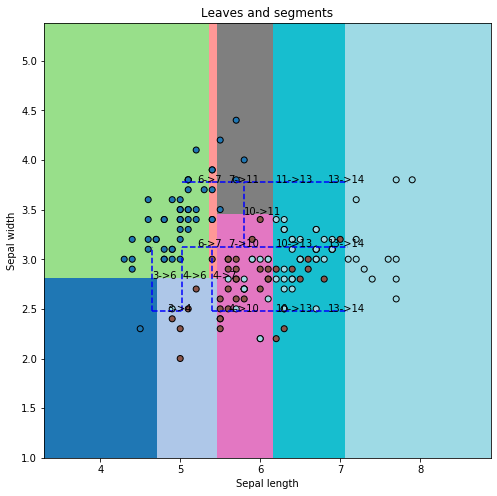

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
draw_border(clr, X, y, incx=1, incy=1, figsize=(6,4), border=False, ax=ax,
            fct=lambda m, x: predict_leaves(m, x))

for edge, segments in neighbors.items():
    for segment in segments:
        # leaves l1, l2 are neighbors
        l1, l2 = edge
        # the common border is [x1, x2]
        x1 = segment[1]
        x2 = segment[2]
        ax.plot([x1[0], x2[0]], [x1[1], x2[1]], 'b--')
        ax.text((x1[0] + x2[0])/2, (x1[1] + x2[1])/2, "%d->%d" % edge)
ax.set_title("Leaves and segments");